In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

# # The following code is used for hiding the warnings and make this notebook clearer.
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [ ]:
## Miscellaneous code to plot decision boundary (ignore) ##

def plot_decision_regions(X, y, classifier, method, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    if method == 'numpy':
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    elif method == 'pytorch':
        inp = torch.tensor([xx1.ravel(), xx2.ravel()], dtype=torch.float, requires_grad=False).T
        Z = np.array([]).reshape(0,1)
        for data in inp:
            out = classifier(data)
            Z = np.vstack((Z, out.data.numpy()))
    else:
        print('Not implemented')
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [ ]:
#defining the activation function 
def sigmoid(x):
  out= 1/(1+np.exp(-x))
  return(out)
#defining derivative of the output
def sigmoid_derivative(x):
  out= x*(1-x)
  return(out)

Creating the class for neural network

In [ ]:
class NN:
  def __init__(self,net_arch):   
    # self is an instance of the class passed to its own function
    # init is a function for class initialization..
    # net_arch is a list carrying number of neurons per hidden layer
    np.random.seed(0)

    self.activation = sigmoid
    self.activation_derivative = sigmoid_derivative
    self.layers = len(net_arch)
    self.arch= net_arch
    self.weights =[]

    # random activation of weights in NN
    for layer in range(self.layers-1):  # self.layers-1 because including i/o layer if we have k layers then there are k-1 weight matrices
      w= 2 * torch.rand(net_arch[layer]+1,net_arch[layer+1]) -1 # trying to make the values with uniform distribution in (-1,1)
                                                                  # size is self.arch[layer]+1 because we need a bias unit on previous layer 
      self.weights.append(w)
    
  def _forward_prop(self,x):
    out = x              
    for i in range(len(self.weights)-1):
      z= np.dot(out[i],self.weights[i])
      feature = self.activation(z)

      #add the bias for the next layer
      feature = np.concatenate((np.ones(1),np.array(feature)))
      out.append(feature)

    # for the last layer we are taking separate dot product as after activation function we don't have to concatenate bias
    z= np.dot(out[-1],self.weights[-1])
    feature = self.activation(z)
    out.append(feature)
    return(out)  
  
  def _back_prop(self,y,target,learning_rate):
    # calculating loss
    error = target - y[-1]    # only the last eentry of y gives the output of the NN during forward propagation
    mse = 0.5 *(error*error)  #0.5 to nullify the factor of 2 after the derivative
    # calculate loss drivative with respect of output
    delta_vec = [error * self.activation_derivative(y[-1])] # mse = 0.5*(activated_y-target)^2 => dmse/dy = error*activation_derivative(y)
    
    # we need to begin from the back, from the next to last layer
    for i in range(self.layers-2, 0, -1):
        error = delta_vec[-1].dot(self.weights[i][1:].T)
        error = error*self.activation_derivative(y[i][1:])
        delta_vec.append(error)

    # Now we need to set the values from back to front
    delta_vec.reverse()

    # Finally, we adjust the weights, using the backpropagation rules
    for i in range(len(self.weights)):
        layer = y[i].reshape(1, self.arch[i]+1)
        delta = delta_vec[i].reshape(1, self.arch[i+1])
        self.weights[i] += learning_rate*layer.T.dot(delta)

  def fit(self, data, labels, learning_rate=0.1, epochs=100):
      #########
      # Training Routine
      #########
      # parameters
      # ----------
      # self:    the class object itself
      # data:    the set of all possible pairs of booleans True or False indicated by the integers 1 or 0
      # labels:  the result of the logical operation 'xor' on each of those input pairs
      #########

      # Add bias units to the input layer - 
      # add a "1" to the input data (the always-on bias neuron)
      ones = np.ones((1, data.shape[0]))
      Z = np.concatenate((ones.T, data), axis=1)
      
      # gradient descent iterations
      for k in range(epochs):
          # display every 10,000th epoch number
          if (k+1) % 10000 == 0:
              print('epochs: {}'.format(k+1))

          # randomly select a training data point
          sample = np.random.randint(X.shape[0])

          # We will now go ahead and set up our feed-forward propagation:
          x = [Z[sample]]
          y = self._forward_prop(x)

          # Now we do our back-propagation of the error to adjust the weights:
          target = labels[sample]
          self._back_prop(y, target, learning_rate)
  

  def predict_single_data(self, x):
      #########
      # the predict function is used to check the prediction result of
      # this neural network.
      # 
      # parameters
      # ----------
      # self:   the class object itself
      # x:      single input data
      #########
      val = np.concatenate((np.ones(1).T, np.array(x)))
      for i in range(0, len(self.weights)):
          val = self.activation(np.dot(val, self.weights[i]))
          val = np.concatenate((np.ones(1).T, np.array(val)))
      return val[1]
  

  def predict(self, X):
      #########
      # the predict function is used to check the prediction result of
      # this neural network.
      # 
      # parameters
      # ----------
      # self:   the class object itself
      # X:      the input data array
      #########
      Y = np.array([]).reshape(0, self.arch[-1])
      for x in X:
          y = np.array([[self.predict_single_data(x)]])
          Y = np.vstack((Y,y))
      return Y

In [ ]:
np.random.seed(0)

# Initialize the NeuralNetwork with
# 2 input neurons
# 2 hidden neurons
# 1 output neuron
net = NN([2,2,1])

# Set the input data
X = np.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = np.array([0, 1, 
                 1, 0])

# Call the fit function and train the network for a chosen number of epochs
net.fit(X, y, epochs=100000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, net.predict_single_data(s))

epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000
epochs: 60000
epochs: 70000
epochs: 80000
epochs: 90000
epochs: 100000
Final prediction
[0 0] 0.02642194835259556
[0 1] 0.9747995429937552
[1 0] 0.9696768329400414
[1 1] 0.023353988380063563


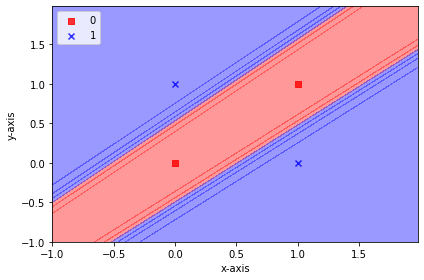

In [ ]:
np.random.seed(0)
plot_decision_regions(X, y, net, 'numpy')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Implementing same neural network with PyTorch


In [ ]:
torch.manual_seed(0)

X= torch.tensor([[0,0],[0,1],[1,0],[1,1]],dtype=torch.float,requires_grad=False)
Y= torch.tensor([0,1,1,0],dtype=torch.float,requires_grad=False)

In [ ]:
class NN(nn.Module):
  def __init__(self):
    super(NN,self).__init__()
    self.fc1= nn.Linear(2,2,True)
    self.fc2= nn.Linear(2,1,True)
  
  def forward(self,x):
    x=self.fc1(x)
    x=torch.sigmoid(x)
    x=self.fc2(x)
    x=torch.sigmoid(x)
    return(x)
model = NN()

In [ ]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

weights_init(model)

In [ ]:
loss_func=nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
epochs = 5000
steps = X.size(0)
for i in range(epochs): # iterate over epoch
    for j in range(steps): # iterate over sample
        # randomly sample the inputs
        sample = np.random.randint(X.size(0))
        x_var = X[sample]
        y_var = Y[sample]
        
        optimizer.zero_grad()   # for zeroing out the gradient of the previous pass

        y_hat = model(x_var)
        
        loss = loss_func.forward(y_hat[0], y_var)
        loss.backward()   #x.grad += dloss/dx accumulates gradient with respect to a parameter
        
        optimizer.step()  # x += -lr * x.grad makes update to the tensor value of the parameter
        
    if i % 500 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

Epoch: 0, Loss: 0.22248335182666779, 
Epoch: 500, Loss: 0.3160940408706665, 
Epoch: 1000, Loss: 0.1796559989452362, 
Epoch: 1500, Loss: 0.29297852516174316, 
Epoch: 2000, Loss: 0.23936912417411804, 
Epoch: 2500, Loss: 0.3022308051586151, 
Epoch: 3000, Loss: 0.22345194220542908, 
Epoch: 3500, Loss: 0.19708336889743805, 
Epoch: 4000, Loss: 0.24158047139644623, 
Epoch: 4500, Loss: 0.03484043851494789, 


In [ ]:
for data in X:
    output = model(data)
    print(data, np.round(output.data.numpy()))

tensor([0., 0.]) [0.]
tensor([0., 1.]) [1.]
tensor([1., 0.]) [1.]
tensor([1., 1.]) [0.]


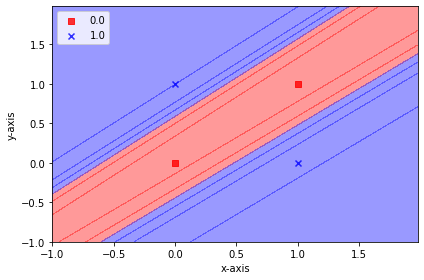

In [ ]:
np.random.seed(0)
plot_decision_regions(X.detach().numpy(), Y.detach().numpy(), model, 'pytorch')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()